# Decision Tree models with weather & holiday features on smoothed dataset
Compare to Model-v0.21-DT_holidays_smoothed notebook

In [2]:
from BorderModel import BorderData, clean_df_subset, create_dummies
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from dbhelper import pd_query

In [26]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            minofday,
            newyears,
            us_mlk,
            us_washington,
            us_memorial,
            us_independence,
            us_columbus,
            us_veterans,
            us_thanksgiving,
            xmas,
            ca_goodfriday,
            ca_victoria,
            ca_canada,
            ca_civic,
            ca_thanksgiving,
            ca_boxing,
            ca_family,
            w.temp_max,
            w.temp_mean,
            w.temp_min,
            w.viz_max,
            w.wind_max,
            w.precip,
            w.rain,
            w.snow,
            w.fog,
            w.thunderstorm,
            w1.temp_max as temp_max_1,
            w1.temp_mean as temp_mean_1,
            w1.temp_min as temp_min_1,
            w1.precip as precip_1,
            w1.rain as rain_1,
            w1.snow as snow_1,
            w1.thunderstorm as thunderstorm_1,
            w2.temp_max as temp_max_2,
            w2.temp_mean as temp_mean_2,
            w2.temp_min as temp_min_2,
            w2.precip as precip_2,
            w2.rain as rain_2,
            w2.snow as snow_2,
            w2.thunderstorm as thunderstorm_2,
            w3.temp_max as temp_max_3,
            w3.temp_mean as temp_mean_3,
            w3.temp_min as temp_min_3,
            w3.precip as precip_3,
            w3.rain as rain_3,
            w3.snow as snow_3,
            w3.thunderstorm as thunderstorm_3
        from mungedata c
        join datefeatures d on c.date = d.date
        left join publicholiday h on c.date::timestamp::date = h.date
        left join weather w on c.date::timestamp::date = w.date
        left join weather w1 on c.date::timestamp::date = w1.date - interval '1 day'
        left join weather w2 on c.date::timestamp::date = w2.date - interval '2 day'
        left join weather w3 on c.date::timestamp::date = w3.date - interval '3 day'
        where
            crossing_id = 1
            and (minute = 0 or minute = 30)
        order by c.date;
        '''

df30 = pd_query(query)

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

## RF with all features - moderate improvement compared to without lead effects

OOB:  0.878140942532
Best score:  0.572547693659
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  111.030326474
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.0188197022733
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.23950349921


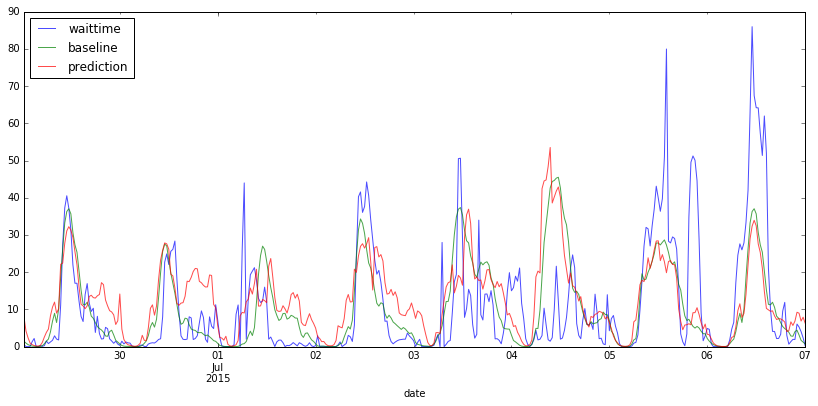

In [28]:
data = BorderData(df30)

model = RandomForestRegressor(n_jobs=-1, n_estimators=100, oob_score=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [29]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'dayofweek' 'week' 'dayofmonth' 'year' 'temp_min' 'wind_max'
 'temp_max_3' 'temp_max' 'temp_max_2' 'temp_min_3' 'temp_min_2'
 'temp_min_1' 'temp_mean_3' 'temp_max_1' 'temp_mean' 'precip_3' 'precip_2'
 'precip_1' 'temp_mean_1' 'precip' 'ca_goodfriday' 'month' 'temp_mean_2'
 'us_veterans' 'rain_2' 'rain_1' 'rain_3' 'rain' 'fog' 'ca_boxing'
 'us_washington' 'ca_canada' 'us_memorial' 'us_mlk' 'snow' 'snow_2'
 'snow_3' 'us_independence' 'us_thanksgiving' 'snow_1' 'viz_max' 'xmas'
 'us_columbus' 'thunderstorm_3' 'newyears' 'ca_civic' 'thunderstorm_1'
 'thunderstorm' 'thunderstorm_2' 'ca_victoria' 'ca_thanksgiving'
 'ca_family']
[0.52083422635548826, 0.080271001841161566, 0.054204102104884376, 0.032177021669273748, 0.02357221780157729, 0.01883266847512656, 0.018528796354141831, 0.015978151170749418, 0.015234201031190199, 0.014973461967208716, 0.014789983438284885, 0.014491907883375045, 0.01424745928456829, 0.014246424243373589, 0.01404393541976413, 0.013156829913098946, 0.01305627

##  GBR worse than without weather lead effects

Best score:  0.572232350714
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  105.369625699
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.068843585365
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.264275168724


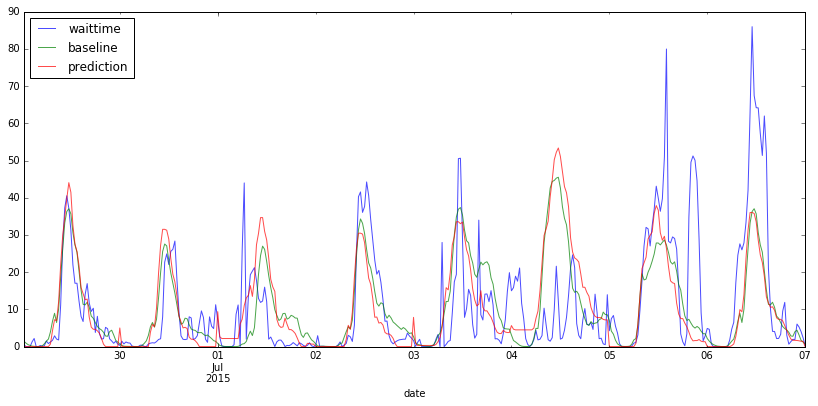

In [30]:
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [31]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'week' 'dayofweek' 'dayofmonth' 'precip_3' 'year' 'temp_min'
 'temp_min_1' 'us_veterans' 'temp_min_2' 'temp_mean_2' 'temp_min_3'
 'precip_2' 'temp_max_2' 'temp_mean_3' 'temp_max_3' 'temp_max_1' 'wind_max'
 'temp_max' 'temp_mean_1' 'precip' 'precip_1' 'month' 'temp_mean'
 'ca_goodfriday' 'ca_canada' 'ca_boxing' 'us_mlk' 'us_washington' 'xmas'
 'thunderstorm_1' 'us_memorial' 'rain_1' 'us_independence' 'snow'
 'us_thanksgiving' 'rain' 'snow_1' 'rain_3' 'rain_2' 'ca_civic' 'fog'
 'ca_victoria' 'newyears' 'viz_max' 'snow_3' 'thunderstorm_3'
 'thunderstorm' 'us_columbus' 'snow_2' 'thunderstorm_2' 'ca_thanksgiving'
 'ca_family']
[0.35687257428494989, 0.075447684534841686, 0.064311301300990664, 0.036143305273296691, 0.032565037599687749, 0.028435353106662432, 0.027786118453981837, 0.025288118282992961, 0.022685092339663197, 0.021672219687407561, 0.021648541157587919, 0.020444494485258393, 0.019485757912107805, 0.01893602844841516, 0.01840271620474819, 0.017993245340189035, 0.017720

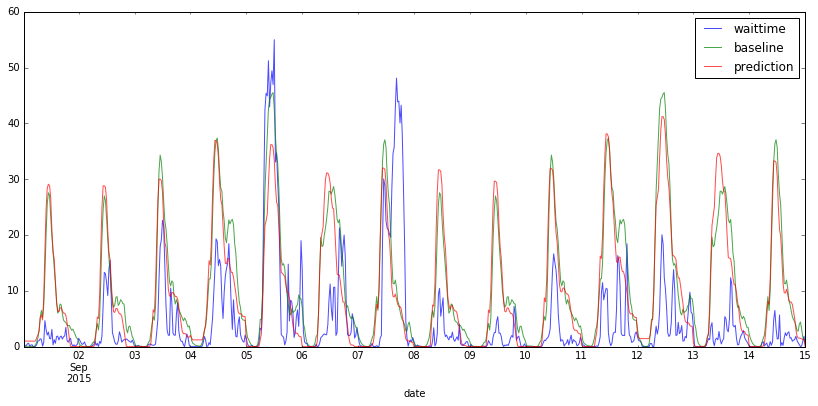

In [32]:
data.plot('9/1/15', '9/15/15');

## What happens when dayofmonth is removed?

Best score:  0.574216160757
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  103.830066682
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.0824487419309
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.275043855216


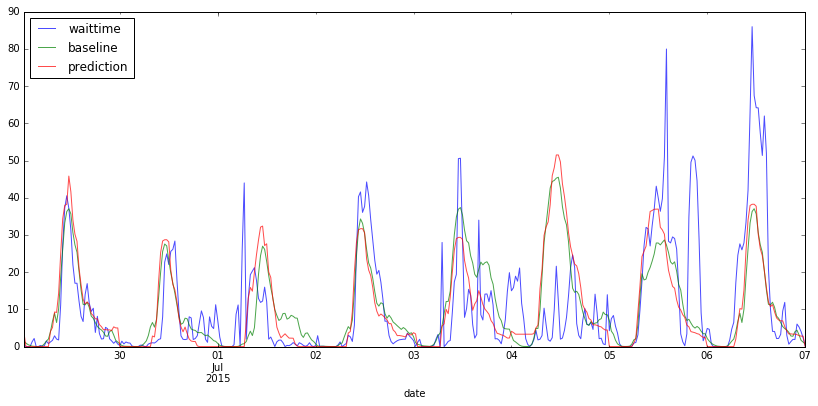

In [33]:
data = BorderData(df30.drop('dayofmonth', 1))
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [34]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'week' 'dayofweek' 'year' 'precip_3' 'temp_min' 'temp_min_1'
 'temp_max_2' 'temp_max_1' 'temp_min_2' 'temp_min_3' 'temp_max_3'
 'precip_2' 'us_veterans' 'temp_mean_3' 'precip' 'temp_max' 'wind_max'
 'temp_mean' 'temp_mean_1' 'temp_mean_2' 'precip_1' 'ca_boxing'
 'ca_goodfriday' 'month' 'ca_canada' 'us_mlk' 'us_washington' 'us_memorial'
 'snow_2' 'xmas' 'us_independence' 'thunderstorm_1' 'rain_3'
 'us_thanksgiving' 'newyears' 'fog' 'snow_1' 'rain_2' 'rain_1' 'viz_max'
 'ca_civic' 'snow' 'thunderstorm_3' 'snow_3' 'rain' 'ca_victoria'
 'us_columbus' 'thunderstorm' 'ca_thanksgiving' 'thunderstorm_2'
 'ca_family']
[0.35964366964801198, 0.087157867160114158, 0.054966949609864348, 0.036915854058994044, 0.032382038756332401, 0.029442293284611433, 0.028672593867228032, 0.022142998724782176, 0.021903786825099168, 0.021044337563300337, 0.020827495995491829, 0.020793640864569567, 0.020677376971034965, 0.020310468919680358, 0.019745004843080987, 0.019110099248745537, 0.01811769893512799

## What happens when week is removed too?
* NOT GOOD

Best score:  0.556253877662
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  105.863569955
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.0644785763887
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.261973668771


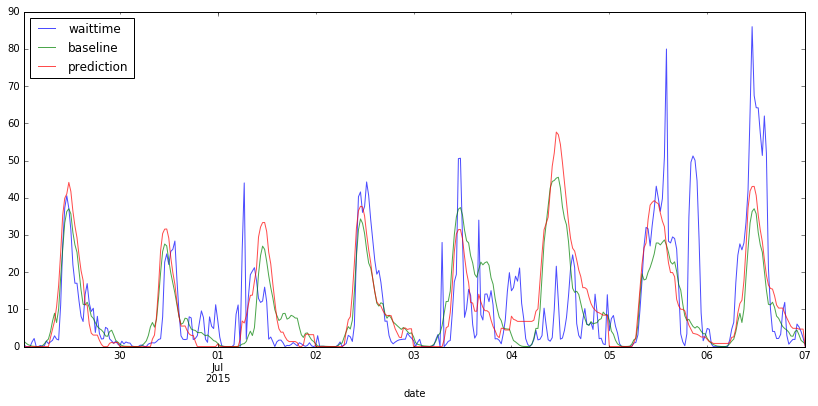

In [35]:
data = BorderData(df30.drop(['dayofmonth', 'week'], 1))
model = GradientBoostingRegressor(subsample=.2, n_estimators=300)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [36]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'dayofweek' 'month' 'precip_3' 'temp_min' 'temp_min_3' 'year'
 'temp_mean_2' 'temp_mean_3' 'temp_min_1' 'wind_max' 'us_veterans'
 'precip_2' 'temp_min_2' 'temp_max_3' 'temp_max' 'temp_max_1' 'temp_mean'
 'temp_max_2' 'precip' 'temp_mean_1' 'precip_1' 'ca_goodfriday' 'ca_boxing'
 'ca_canada' 'us_independence' 'us_washington' 'us_mlk' 'us_thanksgiving'
 'newyears' 'thunderstorm_1' 'xmas' 'snow_1' 'rain_3' 'us_memorial'
 'ca_civic' 'rain' 'viz_max' 'thunderstorm_3' 'snow_2' 'snow_3' 'fog'
 'snow' 'thunderstorm' 'rain_1' 'rain_2' 'ca_victoria' 'us_columbus'
 'ca_thanksgiving' 'ca_family' 'thunderstorm_2']
[0.33567605410216717, 0.064561918658765677, 0.055264770433754953, 0.042006920548886439, 0.034285209195093036, 0.031142710896523179, 0.029121794569423282, 0.028939139789383943, 0.028091499198147733, 0.027526800998747252, 0.025791079864621935, 0.025438769045428012, 0.02539515676053624, 0.024031712703755377, 0.022513220595809607, 0.02139772962612134, 0.0197845028065445, 0.0195301

## Also let's try ExtraTrees 

In [38]:
from sklearn.ensemble import ExtraTreesRegressor

OOB:  0.846370400885
Best score:  0.601605004006
** MSE for last cv fold **
Baseline :  96.154008876
Model    :  105.474333553
** R^2 for last cv fold **
Baseline :  0.15028243136
Model    :  0.0679182770619
** Explained variance for last cv fold **
Baseline :  0.305474073834
Model    :  0.288159581263


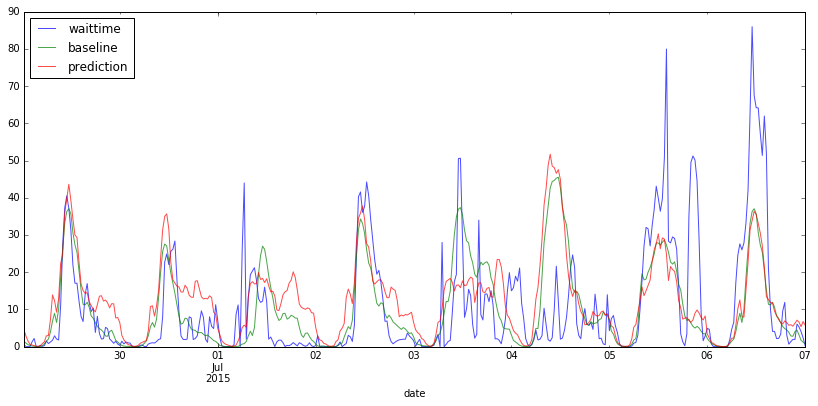

In [39]:
data = BorderData(df30)

model = ExtraTreesRegressor(n_jobs=-1, n_estimators=100, oob_score=True, bootstrap=True)
params = {}
grid = GridSearchCV(model, params, cv=data.cv_train)
grid.fit(data.X_train, data.y_train)
data.predict(grid)
data.print_metrics(grid)
data.plot('6/29/15', '7/7/15');

In [40]:
print data.X.columns.values[np.argsort(grid.best_estimator_.feature_importances_)[::-1]]
print sorted(grid.best_estimator_.feature_importances_)[::-1]

['minofday' 'dayofweek' 'year' 'week' 'month' 'dayofmonth' 'temp_min'
 'wind_max' 'temp_mean' 'temp_min_1' 'temp_min_2' 'precip_3' 'temp_max_3'
 'temp_min_3' 'temp_max_2' 'temp_max' 'temp_mean_3' 'temp_mean_1'
 'temp_mean_2' 'temp_max_1' 'precip_2' 'precip_1' 'precip' 'ca_goodfriday'
 'rain_2' 'us_veterans' 'rain_3' 'rain_1' 'rain' 'fog' 'ca_boxing' 'snow'
 'snow_1' 'snow_3' 'ca_canada' 'snow_2' 'us_washington' 'us_independence'
 'us_memorial' 'us_thanksgiving' 'us_mlk' 'newyears' 'xmas' 'ca_civic'
 'viz_max' 'thunderstorm_3' 'thunderstorm_2' 'thunderstorm' 'us_columbus'
 'thunderstorm_1' 'ca_victoria' 'ca_family' 'ca_thanksgiving']
[0.52056403666092188, 0.074944524739303006, 0.026456387132518765, 0.026277080161357106, 0.023558094326443749, 0.023032720424685717, 0.01550384408683299, 0.014630595352847336, 0.013951118605440389, 0.013648205500828656, 0.013203024736591714, 0.013055459106981032, 0.013013178542683267, 0.012939710806964478, 0.012795040089905478, 0.012780622711542532, 0.012704

## Extra Trees is a good compromise between RF and GBR
Overfits more than GBR, but less than RF
Much faster than GBR